<a href="https://colab.research.google.com/github/YuHan-J-Nam/CODE_2024a_Drug_Classification/blob/master/%EC%BD%94%EB%93%9C_%EB%A7%88%EC%95%BD_%EC%86%8C%EB%B9%84_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 로드

In [55]:
import numpy as np
import pandas as pd

# 데이터 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## 데이터 불러오기 및 파악

In [2]:
# 데이터 읽어오기
raw_df = pd.read_csv('./data/Drug_Consumption.csv')

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1884 non-null   int64  
 1   Age        1884 non-null   object 
 2   Gender     1884 non-null   object 
 3   Education  1884 non-null   object 
 4   Country    1884 non-null   object 
 5   Ethnicity  1884 non-null   object 
 6   Nscore     1884 non-null   float64
 7   Escore     1884 non-null   float64
 8   Oscore     1884 non-null   float64
 9   AScore     1884 non-null   float64
 10  Cscore     1884 non-null   float64
 11  Impulsive  1884 non-null   float64
 12  SS         1884 non-null   float64
 13  Alcohol    1884 non-null   object 
 14  Amphet     1884 non-null   object 
 15  Amyl       1884 non-null   object 
 16  Benzos     1884 non-null   object 
 17  Caff       1884 non-null   object 
 18  Cannabis   1884 non-null   object 
 19  Choc       1884 non-null   object 
 20  Coke    

In [3]:
# 결측치 확인
raw_df.isnull().sum().sum()

0

결측치는 없는 데이터입니다.

In [4]:
# 데이터 속 수치형 데이터의 통계량 확인
raw_df.describe()

,ID,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS
count,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000,1884.000000
mean,945.796178,-0.000119,0.000143,-0.000225,0.000242,-0.000383,0.007335,-0.002667
std,544.877779,0.998345,0.997625,0.996402,0.997481,0.997787,0.954674,0.963575
min,2.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.750000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.500000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.250000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [5]:
# 데이터 속 범주형 데이터의 통계량 확인
raw_df.describe(include='object')

,Age,Gender,Education,Country,Ethnicity,Alcohol,Amphet,Amyl,Benzos,Caff,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
count,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884,...,1884,1884,1884,1884,1884,1884,1884,1884,1884,1884
unique,6,2,9,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,5,7
top,18-24,M,"Some college or university, no certificate or ...",UK,White,CL5,CL0,CL0,CL0,CL6,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
freq,643,943,506,1043,1720,758,976,1304,1000,1384,...,1020,1604,1489,1093,1068,1428,981,610,1876,1454


## 데이터 탐색: EDA (Exploratory Data Analysis)

![Data Process](./images/encoding.png)

#### 데이터를 독립변수와 종속변수로 분리

In [6]:
# 데이터의 독립변수와 종속변수를 분리
drug_list = raw_df.columns[13:]

raw_X = raw_df.drop(drug_list, axis=1)
raw_Y = raw_df[drug_list]

### 데이터 분포 시각화

#### 독립변수 (범주형 피쳐)

In [7]:
# 독립변수 중 범주형 컬럼 리스트로 출력
categorical_columns = raw_X.select_dtypes(include='object').columns
print(categorical_columns)

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity'], dtype='object')


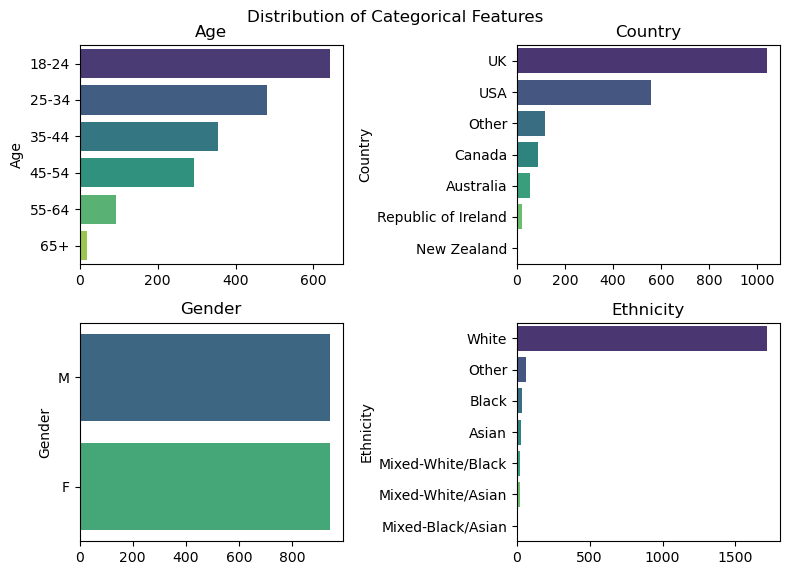

In [8]:
# 범주형 독립변수 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

axes = axes.flatten()
for i, col in enumerate(['Age', 'Country', 'Gender', 'Ethnicity']):
    ax = axes[i]
    sns.countplot(y=col, data=raw_X, ax=ax, hue=col, order=raw_X[col].value_counts().index, hue_order=raw_X[col].value_counts().index, palette='viridis')
    ax.set_title(col)
    ax.set_xlabel('')
    
plt.suptitle('Distribution of Categorical Features', y=0.95)

plt.tight_layout()
plt.show()

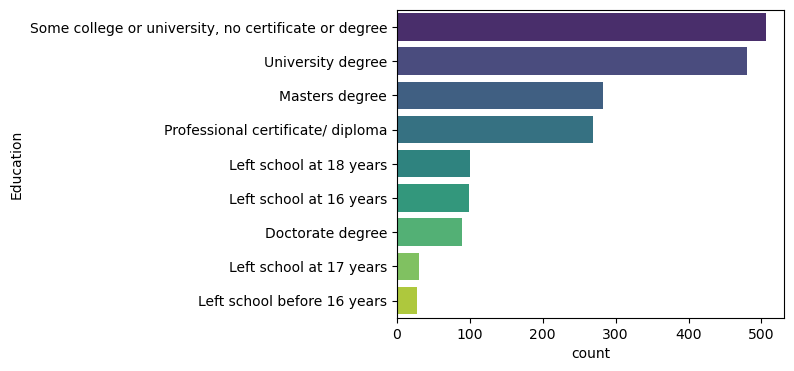

In [9]:
plt.figure(figsize=(5, 4))
sns.countplot(y='Education', data=raw_X, hue='Education', order=raw_X['Education'].value_counts().index, hue_order=raw_X['Education'].value_counts().index, palette='viridis')
plt.show()

### 독립변수 (수치형 피쳐)

In [10]:
# 독립변수 중 수치형 컬럼 리스트로 출력
numerical_columns = raw_X.select_dtypes(include='float').columns
print(numerical_columns)

Index(['Nscore', 'Escore', 'Oscore', 'AScore', 'Cscore', 'Impulsive', 'SS'], dtype='object')


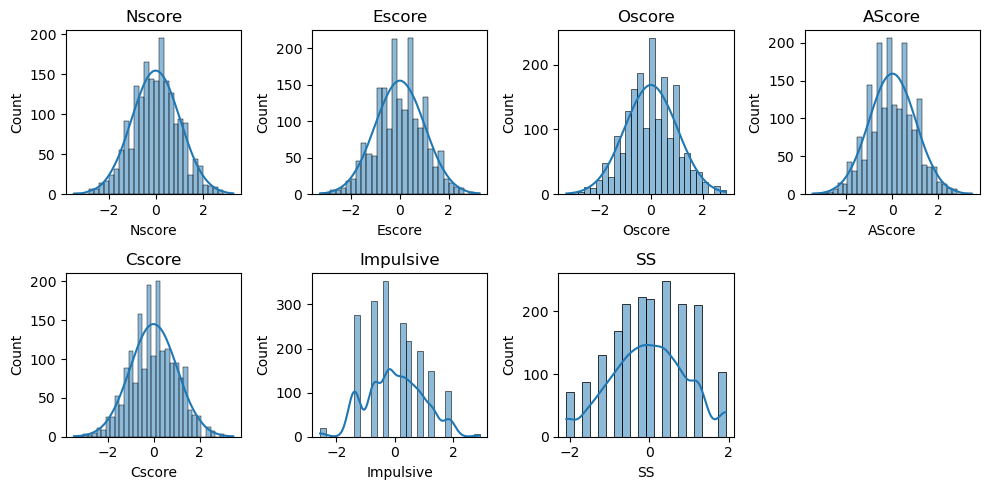

In [11]:
# 수치형 독립변수 분포 시각화
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(raw_X[col], ax=ax, kde=True)
    ax.set_title(col)
    
axes[7].set_visible(False)
    
plt.tight_layout()
plt.show()

### 종속 변수
#### 약물 종류
|Column Name|Drug|Column Name|Drug|
|---|---|---|---|
|**Amphet**| 암페타민|**Heroin**| 헤로인 |
|**Amyl**| 아밀 나이트라이트 |**Ketamine**| 케타민 |
|**Benzos**| 벤조디아제핀 |**Legalh**| 합법적 환각제 |
|**Caff**| 카페인 |**LSD**| LSD |
|**Cannabis**| 마리화나(대마) |**Meth**| 메타돈 |
|**Choc**| 초콜릿 |**Mushroom**| 환각 버섯 |
|**Coke**| 코카인 |**Nicotine**| 니코틴 |
|**Crack**| 크랙 코카인 |**Semer**| 허구의 약물 세메론 (즉, 대조군) | 
|**Ecstasy**| 엑스터시 |**VSA**| 휘발성 물질 남용 |

#### 약물 사용 여부
![CL Description](./images/CL_scale.png)

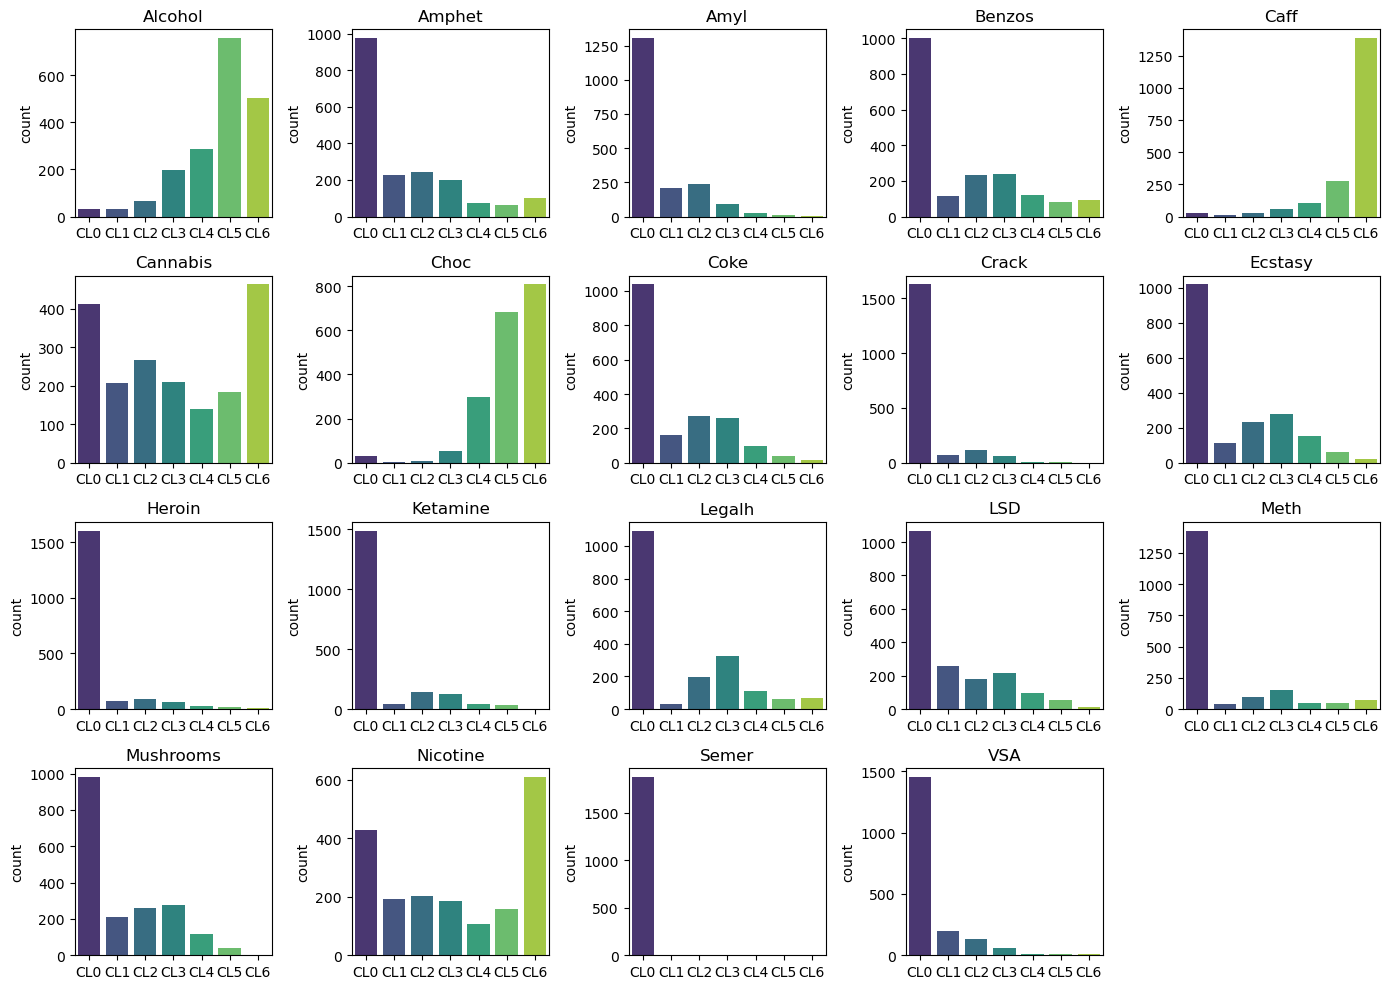

In [12]:
# 데이터 시각화를 위한 figure와 axes 생성
fig, axes = plt.subplots(4, 5, figsize=(14, 10))

# axes를 1차원으로 flatten
axes = axes.flatten()
for i, drug in enumerate(drug_list):
    # 현재 subplot의 axes 선택
    ax = axes[i]
    # 현재 subplot에 countplot 그리기
    sns.countplot(x=drug, data=raw_Y, ax=ax,
                  order=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'],
                  # 색상 설정 (viridis)
                  hue=drug, palette='viridis',
                  hue_order=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
        
    # 현재 subplot의 title 설정
    ax.set_title(drug)
    ax.set_xlabel('')
    
# 필요없는 subplot 지우기
axes[19].set_visible(False)

# 그래프 간 간격 조정
fig.tight_layout()
plt.show()

### 의심되는 데이터 제거

In [13]:
# Semer의 데이터 분포 확인
raw_Y['Semer'].value_counts()

Semer
CL0    1876
CL2       3
CL3       2
CL1       2
CL4       1
Name: count, dtype: int64

Semer는 가상약물이기 때문에 Semer에 대한 대답이 'CL0'이 아닌 샘플들은 모두 배제하도록 하겠습니다.

In [14]:
# Semer 데이터중 CL0이 아닌 데이터의 index 추출
remove_idx = raw_Y[raw_Y['Semer'] != 'CL0'].index

# X, Y에서 해당 index 제거
X = raw_X.drop(remove_idx).reset_index(drop=True)
Y = raw_Y.drop(remove_idx).reset_index(drop=True)

# Semer 컬럼 제거
Y = Y.drop('Semer', axis=1)

# 사용하지 않는 ID 컬럼 제거
X.drop('ID', axis=1, inplace=True)

## 수치형 데이터로 변형
### 종속변수

In [15]:
# 종속변수를 수치형 데이터로 변형
Y_quantified = Y.replace({'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6})

In [16]:
Y_quantified.head()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
0,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0
1,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0
2,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0
3,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0
4,2,0,0,0,6,0,4,0,0,0,0,0,0,0,0,0,6,0


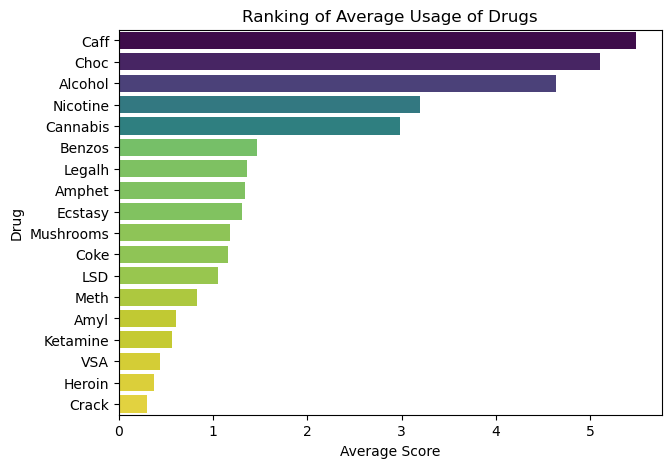

In [17]:
# 약물 별 평균 점수 시각화
drug_mean = Y_quantified.mean().sort_values(ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=drug_mean.values, y=drug_mean.index, hue=drug_mean.values, palette='viridis_r')

plt.title('Ranking of Average Usage of Drugs')
plt.xlabel('Average Score')
plt.ylabel('Drug')
plt.legend([],[], frameon=False)

plt.show()

#### 약물간 사용여부 상관계수 확인

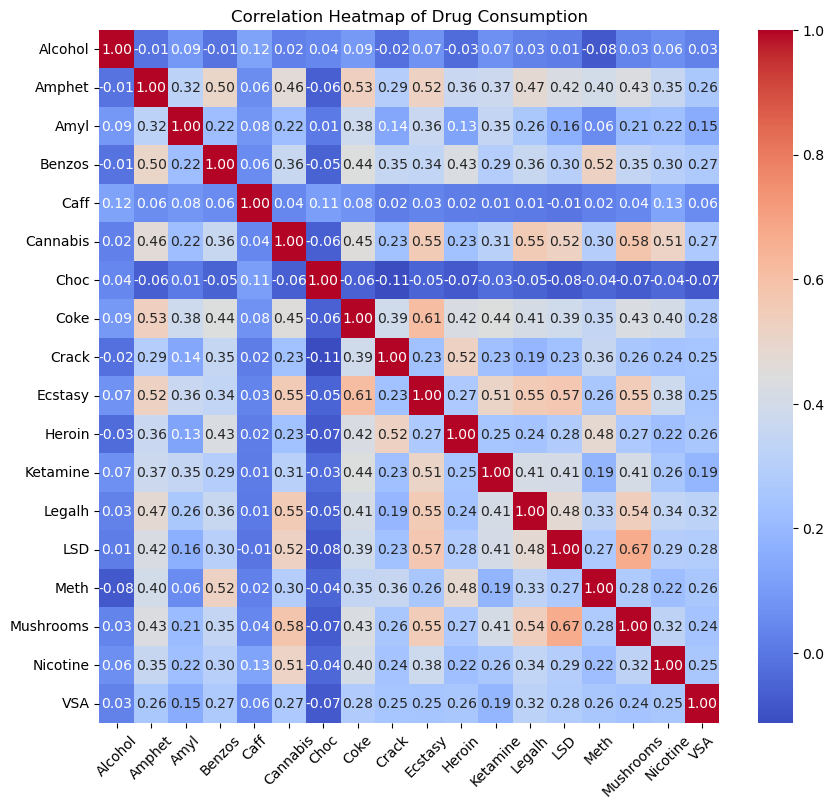

In [18]:
# Create correlation heatmap for y
plt.figure(figsize=(10, 9))
sns.heatmap(Y_quantified.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.xticks(rotation=45)
plt.title('Correlation Heatmap of Drug Consumption')
plt.show()

알코올, 카페인, 초콜릿에 대한 답변은 다른 약물들과의 상관관계가 확연히 낮은 것을 볼 수 있습니다.

그러므로 해당 약물들은 다른 약물 사용과 큰 관계가 없는 것으로 볼 수 있습니다.

In [27]:
# 약물 복용 여부와 상관관계가 낮은 컬럼 분류 및 제거
less_correlated = ['Alcohol', 'Caff', 'Choc']
Y_important = Y.drop(less_correlated, axis=1)
Y_important_q = Y_quantified.drop(less_correlated, axis=1)

### 독립변수

#### 범주형 변수 인코딩 처리
Age, Gender, Education, Country, Ethnicity를 인코딩 해주겠습니다.

- Age, Education 피쳐들은 비록 범주형이지만 범주간의 관계가 정보를 나타냅니다. (Ordinal Encoding)

- Gender 컬럼은 M/F 밖에 없음으로 간단하게 0/1로 변환해 주겠습니다. (Replacement Encoding)

- Country, Ethnicity 피쳐들은 범주간의 관계가 따로 없습니다. (One Hot Encoding)

In [20]:
X_encoded = X.copy()

# 1. Ordinal Encoding을 사용하여 Age, Education 컬럼 변환
age_OE = OrdinalEncoder(categories=[['18-24', '25-34', '35-44', '45-54', '55-64', '65+']])
X_encoded['Age'] = age_OE.fit_transform(X_encoded[['Age']])

edu_OE = OrdinalEncoder(categories=[['Left school before 16 years', 'Left school at 16 years', 'Left school at 17 years', 'Left school at 18 years', 
                                     'Some college or university, no certificate or degree', 'Professional certificate/ diploma', 
                                     'University degree', 'Masters degree', 'Doctorate degree']])
X_encoded['Education'] = edu_OE.fit_transform(X_encoded[['Education']])

# 2. Gender 컬럼 변환 (M-> 0, F-> 1)
X_encoded['Gender'] = X_encoded['Gender'].map({'M': 0, 'F': 1})

# 3. One Hot Encoding을 사용하여 Country, Ethnicity 컬럼 변환
one_hot_encoder = OneHotEncoder(sparse_output=False)
X_encoded = pd.concat([X_encoded, pd.DataFrame(one_hot_encoder.fit_transform(X_encoded[['Country', 'Ethnicity']]), 
                                               columns=one_hot_encoder.get_feature_names_out(['Country', 'Ethnicity'])
                                               )], axis=1)
X_encoded.drop(['Country', 'Ethnicity'], axis=1, inplace=True)

In [21]:
X_encoded.head()

,Age,Gender,Education,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,...,Country_Republic of Ireland,Country_UK,Country_USA,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed-Black/Asian,Ethnicity_Mixed-White/Asian,Ethnicity_Mixed-White/Black,Ethnicity_Other,Ethnicity_White
0,1.0,0,8.0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,0,5.0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1,7.0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.0,1,8.0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,1,3.0,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
# 지금까지 정리한 데이터를 저장
pd.concat([X_encoded, Y], axis=1).to_csv('./data/drug_consumption_preprocessed.csv', index=False)

# 질문 제기 및 데이터 모델링 & 분석

### 각 샘플 별 사용해본 약물 개수를 계산

In [28]:
# y의 열 중 CL1~6의 개수를 계산
y_num_used_drug = Y_important.apply(lambda x: x.isin(['CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']).sum(), axis=1)

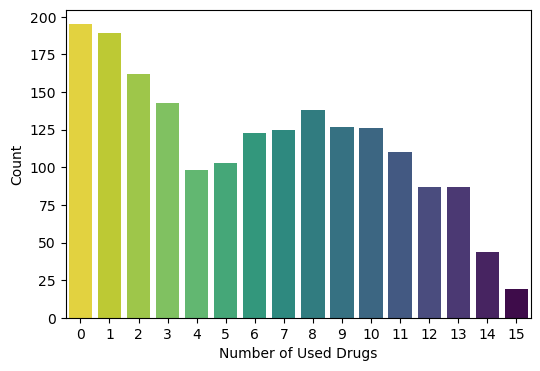

In [29]:
# y_num_used_drug의 분포 시각화
plot_arr = y_num_used_drug.value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=plot_arr.index, y=plot_arr.values, hue=plot_arr.index, palette='viridis_r', legend=False)
plt.xlabel('Number of Used Drugs')
plt.ylabel('Count')
plt.show()

## 질문 2: 샘플들을 군집화하여 약물 투여 패턴을 분석 및 예측할 수 있을까?
특정 약물을 사용하는 사람들은 다른 약물도 같이 

c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Parameter: {'n_clusters': 2} Score 0.32639079443738533


c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Parameter: {'n_clusters': 3} Score 0.2707567066518242


c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Parameter: {'n_clusters': 4} Score 0.24942802002740785


c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Parameter: {'n_clusters': 5} Score 0.2555793352158456


c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Parameter: {'n_clusters': 6} Score 0.24647496781880968


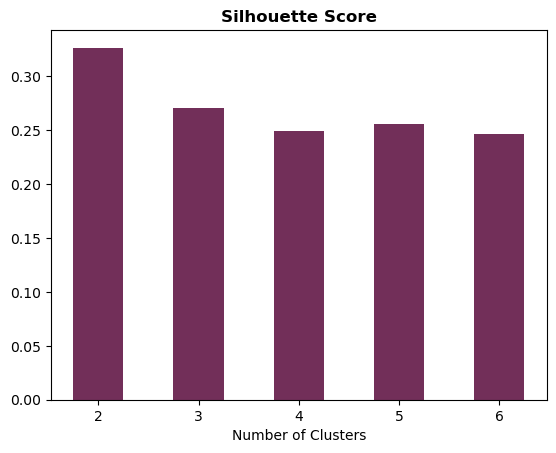

In [30]:
# import ParameterGrid and KMeans from sklearn
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn import metrics

# candidate values for our number of cluster
parameters = np.arange(2, 7)
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(Y_important_q)          # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(Y_important_q, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

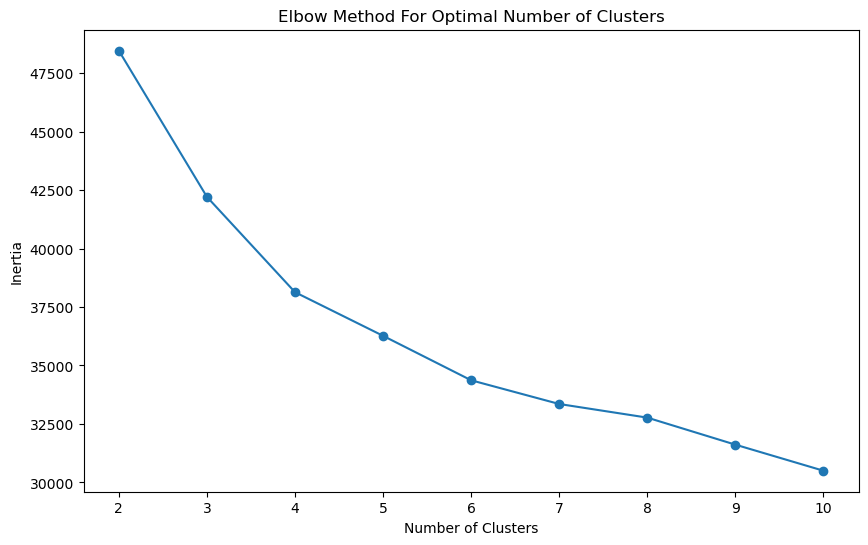

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method for determining the optimal number of clusters
inertia = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Y_important_q)
    inertia.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# KMeans 알고리즘을 사용하여 클러스터링을 수행
num_clusters = 4  # 4개의 클러스터로 설정
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(Y_important_q)

# 클러스터 결과를 데이터프레임에 추가
Y_important_q['Cluster'] = clusters

# PCA를 사용하여 2차원으로 축소 (시각화를 위함)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(Y_important_q.drop(columns=['Cluster']))

# 각 클러스터별 각 약물별 사용 평균을 계산
cluster_averages = Y_important_q.groupby('Cluster').mean()

c:\Users\YuHan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


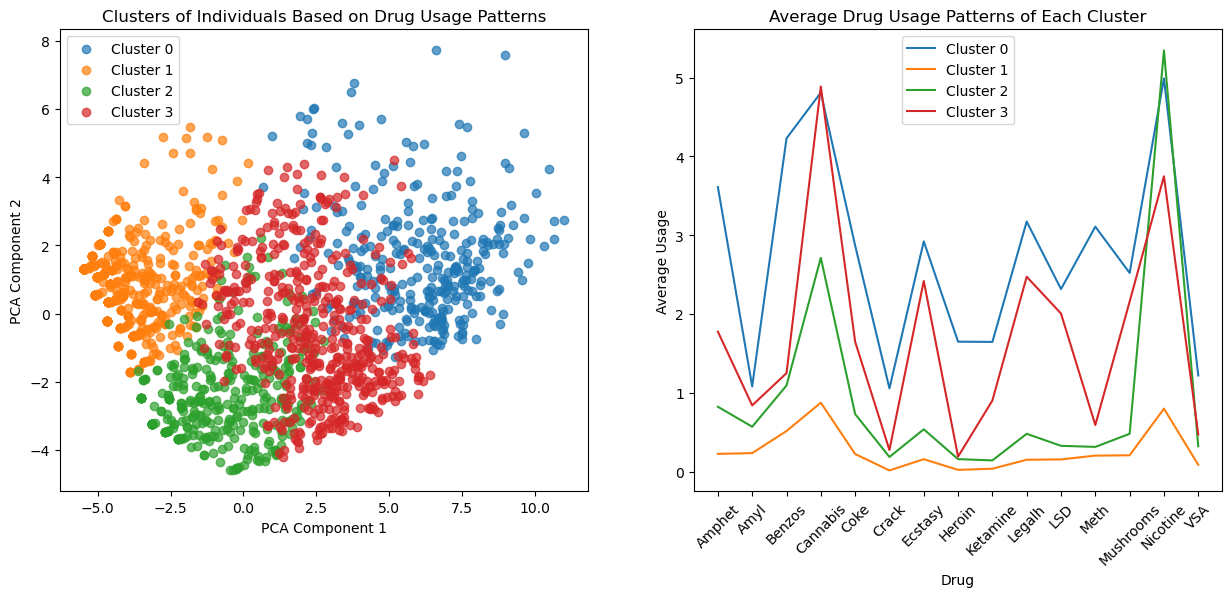

In [80]:
# Cluster한 결과를 바탕으로 각 클러스터의 특징을 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for cluster in range(num_clusters):
    # In plot 0, visualize the clusters according to the PCA components
    axes[0].scatter(pca_components[clusters == cluster, 0], pca_components[clusters == cluster, 1], label=f'Cluster {cluster}', alpha=0.7)
    axes[1].plot(cluster_averages.columns, cluster_averages.loc[cluster], label=f'Cluster {cluster}')

axes[0].set_title('Clusters of Individuals Based on Drug Usage Patterns')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].legend()

axes[1].set_title('Average Drug Usage Patterns of Each Cluster')
axes[1].set_xlabel('Drug')
axes[1].set_ylabel('Average Usage')
axes[1].set_xticks(range(len(cluster_averages.columns)))
axes[1].set_xticklabels(cluster_averages.columns, rotation=45)
axes[1].legend()

plt.show()

### 클러스터 별 약물 사용 평균

테이블은 각 클러스터 내에서 각 약물의 평균 사용 패턴을 보여줍니다. 이러한 평균에 기반하여 각 클러스터가 무엇을 나타내는지 요약한 내용은 다음과 같습니다:

- **클러스터 1:**
  - 거의 모든 약물의 사용이 매우 낮음.
  - 이 클러스터는 약물을 거의 사용하지 않는 개인들을 나타냅니다.

- **클러스터 2:**
  - 대마초와 니코틴의 중간 정도 사용.
  - 다른 약물의 사용은 낮음.
  - 이 클러스터는 가끔씩 약물을 사용하는 개인들을 나타냅니다.

- **클러스터 3:**
  - 대마초의 높은 사용과 상대적으로 높은 엑스터시, LSD, 니코틴 사용.
  - 이 클러스터는 특히 대마초와 환각제를 많이 사용하는 개인들을 나타냅니다.

- **클러스터 0:**
  - 대마초, 코카인, 케타민, LSD, 메타돈, 니코틴 등 여러 약물의 매우 높은 사용.
  - 이 클러스터는 다양한 약물을 광범위하게 사용하는 개인들을 나타냅니다.

In [45]:
# 새로운 모델 타겟값을 생성
y_clustered = Y_important_q['Cluster'].map({0: 3, 1: 0, 2: 1, 3: 2})

In [51]:
# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_clustered, test_size=0.2, random_state=42)

In [52]:
# Random Forest 모델 생성
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
# Train, Test 정확도 출력
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Train Accuracy: 1.0000
Test Accuracy: 0.5346


In [58]:
# RandomizedSearchCV를 위한 하이퍼파라미터 설정
params = {
    'n_estimators': np.arange(25, 201, 25),
    'max_features': np.arange(1, 11),
    'min_samples_split': np.arange(2, 8),
    'min_samples_leaf': np.arange(1, 5)
}

# RandomizedSearchCV 수행
rand_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1, n_iter=100, random_state=42, verbose=1)
rand_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
rand_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 4}

In [61]:
# 최적의 모델로 예측
best_rf = rand_search.best_estimator_
best_rf.fit(X_train, y_train)

# Train, Test 정확도 출력
train_acc = accuracy_score(y_train, best_rf.predict(X_train))
test_acc = accuracy_score(y_test, best_rf.predict(X_test))

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Confusion Matrix 출력
confusion_matrix(y_test, best_rf.predict(X_test))

Train Accuracy: 0.9473
Test Accuracy: 0.5691


array([[133,   6,  10,   4],
       [ 41,   7,  16,   3],
       [ 21,   7,  51,  21],
       [  3,   2,  28,  23]], dtype=int64)

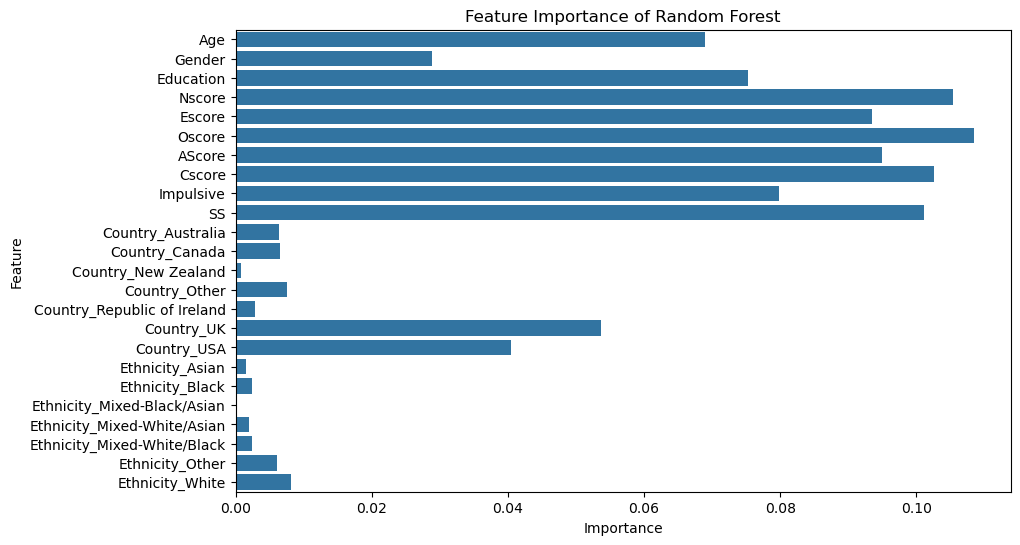

In [62]:
# Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=rf.feature_importances_, y=X_encoded.columns)

plt.title('Feature Importance of Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()

## CL3 이상이 없는 사람들 수 계산

In [71]:
# 새로운 데이터프레임 생성 (CL0~CL2: 0, CL3~CL6: 1)
Y_binary = Y_important.apply(lambda x: x.isin(['CL3', 'CL4', 'CL5', 'CL6']), axis=0)

# 최근 1년간 약물 사용 여부
y_used_drug_in_last_year = Y_binary.sum(axis=1) > 0
y_used_drug_in_last_year.value_counts()

True     1347
False     529
Name: count, dtype: int64

In [72]:
# Train, Test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_used_drug_in_last_year, test_size=0.3, random_state=42, stratify=y_used_drug_in_last_year)

In [73]:
# Random Forest 모델 생성
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
# Train, Test 정확도 출력
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Train Accuracy: 1.0000
Test Accuracy: 0.8028


In [77]:
# RandomizedSearchCV를 위한 하이퍼파라미터 설정
params = {
    'n_estimators': np.arange(25, 201, 25),
    'max_features': np.arange(1, 11),
    'min_samples_split': np.arange(2, 8),
    'min_samples_leaf': np.arange(1, 5)
}

# RandomizedSearchCV 수행
rand_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1, n_iter=100, random_state=42, verbose=1)
rand_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
rand_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 8}

In [78]:
# 최적의 모델로 예측
best_rf = rand_search.best_estimator_
best_rf.fit(X_train, y_train)

# Train, Test 정확도 출력
train_acc = accuracy_score(y_train, best_rf.predict(X_train))
test_acc = accuracy_score(y_test, best_rf.predict(X_test))

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Train Accuracy: 0.9513
Test Accuracy: 0.8082


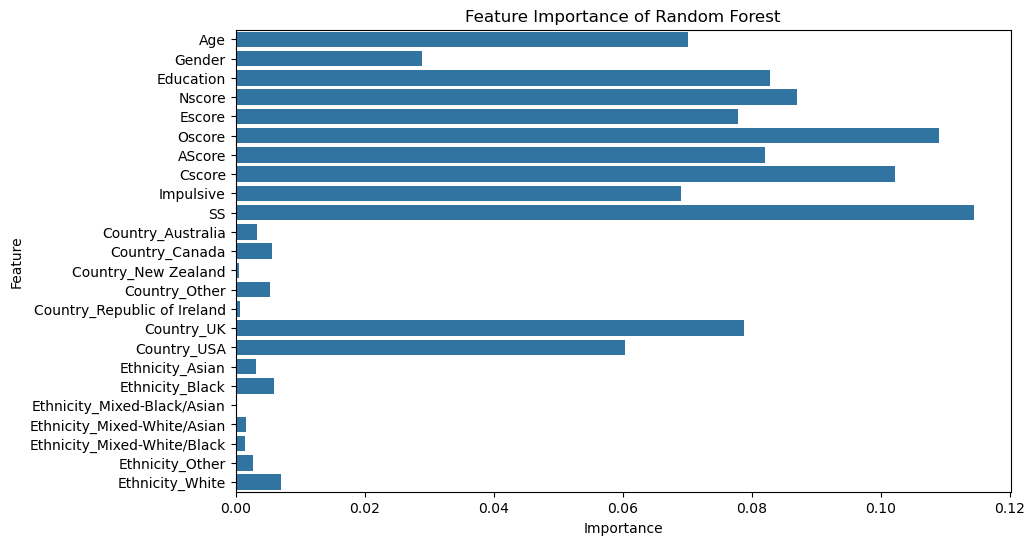

In [79]:
# Confusion Matrix 출력
confusion_matrix(y_test, best_rf.predict(X_test))

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=rf.feature_importances_, y=X_encoded.columns)

plt.title('Feature Importance of Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()

## 특정 마약을 최근 10년간 하지 않은 사람들의 특징 파악

In [17]:
# y의 열 중 CL1이 포함된 열의 index 추출
y_CL1_idx = Y[Y.drop(less_correlated, axis=1).eq('CL1').any(axis=1)].index
y_CL1_idx

Index([   1,    3,    5,    8,    9,   10,   11,   12,   14,   15,
       ...
       1833, 1837, 1842, 1850, 1851, 1853, 1856, 1861, 1865, 1870],
      dtype='int64', length=732)

In [18]:
# y의 열 중 CL2, CL3, CL4, CL5, CL6이 하나도 없는 열의 index 추출
y_no_idx = Y[~Y.drop(less_correlated, axis=1).isin(['CL2', 'CL3', 'CL4', 'CL5', 'CL6']).all(axis=1)].index

print(len(y_no_idx))
print(y_no_idx)

1868
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875],
      dtype='int64', length=1868)


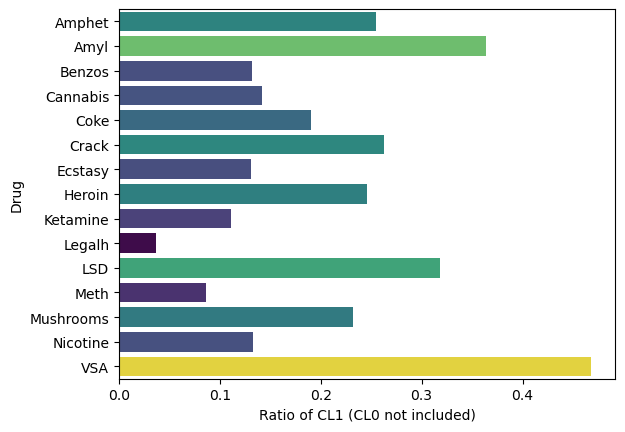

In [19]:
# 약물 별 CL1 비율 계산
y_temp = Y.drop(less_correlated, axis=1)

CL1_ratio = y_temp.apply(lambda x: x.value_counts()['CL1'] / (len(x)-x.value_counts()['CL0']), axis=0)

sns.barplot(y=y_temp.columns, x=CL1_ratio, hue=CL1_ratio, palette='viridis')

plt.ylabel('Drug')
plt.xlabel('Ratio of CL1 (CL0 not included)')
plt.legend([],[], frameon=False)
plt.show()

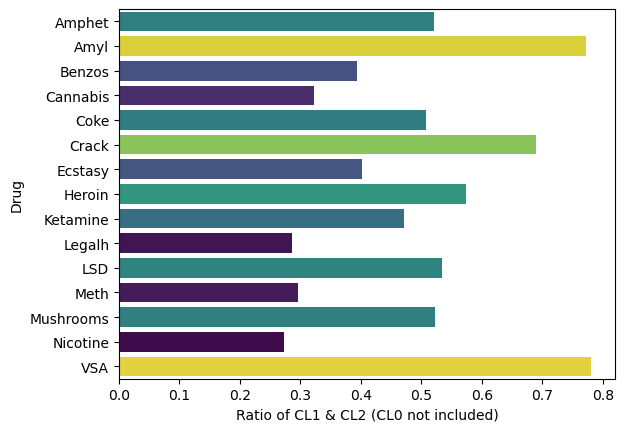

In [20]:
# 약물 별 CL1 + CL2 비율 계산
CL2_ratio = y_temp.apply(lambda x: x.value_counts()['CL2'] / (len(x)-x.value_counts()['CL0']), axis=0)

sns.barplot(y=y_temp.columns, x=CL1_ratio+CL2_ratio, hue=CL1_ratio+CL2_ratio, palette='viridis')

plt.ylabel('Drug')
plt.xlabel('Ratio of CL1 & CL2 (CL0 not included)')
plt.legend([],[], frameon=False)
plt.show()

In [21]:
# Calculate number of CL2~CL6 per column in y_temp
n_CL2_to_6 = y_temp.apply(lambda x: x.isin(['CL2', 'CL3', 'CL4', 'CL5', 'CL6']).sum(), axis=0)

### 중독 위험군 분류
##### 고위험군

11. 헤로인
9. 크랙
7. 코카인
17. 니코틴
1. 알코올
15. 메타돈

##### 중등도 위험군

12. 케타민
10. 엑스터시
2. 암페타민
4. 벤조디아제핀
5. 대마초

##### 저위험군(비교적)

14. LSD
3. 아질산 아밀
13. 합법적 환각제
8. 카페인
6. 초콜릿
16. 버섯